# Rusty Bargain Car Value Model

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## 1. Initialization

In [44]:
# Load libraries
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
import warnings
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from IPython.display import display, HTML
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)           # Prevent line wrapping
pd.set_option('display.max_colwidth', None) # Show full contents of cells


In [45]:
# Functions

state = np.random.RandomState(seed=777)  # Establish pseudorandom conditions up-front

# -- Custom Cross-Validation Function (75% Training / 25% Validation)
def repeated_random_cv_full(feat_train, target_train, model, n_repeats=5, val_size=0.25, rng=state, cat_features=None):
    all_preds = []
    all_actuals = []
    all_split_ids = []
    rmse_list = []

    # Time tracking
    total_train_time = 0
    total_pred_time = 0
    
    for i in range(n_repeats): # Iterates over 5x 75/25 fols with a different seedd spawned from RandomState 777
        seed_i = rng.randint(0, 10**6)
        feat_subtrain, feat_val, target_subtrain, target_val = train_test_split(
            feat_train, target_train, test_size=val_size, random_state=seed_i
        ) 

        start_train = time.time()
        if cat_features:
            model.fit(feat_subtrain, target_subtrain.values, categorical_feature=cat_features)
        else:
            model.fit(feat_subtrain, target_subtrain.values) # Train the model using the 75% training set from the outer split
        total_train_time += time.time() - start_train

        start_pred = time.time()
        preds = model.predict(feat_val)
        total_pred_time += time.time() - start_pred
    
        all_preds.extend(preds) # Capture all iteration predictions
        all_actuals.extend(target_val.values) # Capture all validation actuals
        all_split_ids.extend([i + 1] * len(target_val)) # Document the iteration ID

        rmse = np.sqrt(mean_squared_error(target_val, preds))
        rmse_list.append(rmse)
   
    preds_df = pd.DataFrame({ # Summarize in a neat table
        'split_id': all_split_ids,
        'predicted_price': all_preds,
        'actual_price': all_actuals,
    })

    avg_rmse = np.mean(rmse_list)
    avg_train_time = total_train_time / n_repeats
    avg_pred_time = total_pred_time / n_repeats

    print(f"Avg RMSE: {avg_rmse:.2f}")
    print(f"Avg Training Time per Fold: {avg_train_time:.4f} seconds")
    print(f"Avg Prediction Time per Fold: {avg_pred_time:.4f} seconds")

    return {
        'rmse': avg_rmse,
        'train_time': avg_train_time,
        'pred_time': avg_pred_time,
        'preds_df': preds_df
    } 

# --Convert camel case to snake case
def camel_to_snake(name):
    result = []
    for i, char in enumerate(name):
        if char.isupper() and i!= 0 and not name[i-1].isupper():
            result.append('_')
        result.append(char.lower())
    return ''.join(result)

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Looks great! You can also convert columns to snake case using the following piece of code: 
    
    
    df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()

    
</div>

In [46]:
# Load the data

df = pd.read_csv('../data/car_data.csv')

## 2. Data Preparation

In [47]:
# Review the data set
display(df.info())
print()
print('There are', df.duplicated().sum(), 'duplicated rows.')
print()
display(df.sample(5))
print()
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None


There are 262 duplicated rows.



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
337098,29/03/2016 17:39,4700,small,2007,manual,68,polo,150000,10,petrol,volkswagen,no,29/03/2016 00:00,0,30659,05/04/2016 12:48
333075,12/03/2016 15:40,999,sedan,1997,manual,75,golf,150000,4,petrol,volkswagen,no,12/03/2016 00:00,0,33647,14/03/2016 07:17
138485,03/04/2016 22:51,3300,small,2005,manual,101,ibiza,150000,12,petrol,seat,no,03/04/2016 00:00,0,22417,06/04/2016 00:16
185381,26/03/2016 16:50,290,NaN,2000,NaN,0,corsa,150000,0,NaN,opel,NaN,26/03/2016 00:00,0,60326,27/03/2016 14:39
184779,01/04/2016 04:36,300,sedan,1997,manual,115,vectra,150000,3,petrol,opel,NaN,01/04/2016 00:00,0,27721,07/04/2016 06:15


,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


__CONCLUSIONS & COMMENTARY:__
- The column names are in CamelCase and need to be converted to snake case.
- There are 262 duplicated rows.
- There appears to be a varying number of missing values in many of the columns, which will be cleaned in the forthcoming cells.
- The `describe` function has picked up on some problematic numerical values, such as:
    - `Price`: This is the target column, and it is not likely that there are cars sold for €0.
    - Multiple columns, such as `RegistrationYear` and `Power` have nonsensical values (for example, there hasn't been a year 9999 and a 20,000 hp vehicle is not real.)
- These troubesome values shall be dealt with in the following code.

In [48]:


# Convert multiple columns to datetime
date_cols = ['DateCrawled', 'DateCreated', 'LastSeen']
df[date_cols] = df[date_cols].apply(
    lambda col: pd.to_datetime(col, format='%d/%m/%Y %H:%M', errors='coerce')
)

# Rename/format columns
df.columns = [camel_to_snake(col) for col in df.columns]
display(df.columns)
print()




Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

- Dates converted to usable data.
- Columns converted from `CamelCase` to `snake_case`.

In [49]:
# Missing Values
miss = df.isna().sum()
miss_perc = 100 * miss / len(df)
missing_df = pd.DataFrame({
    'missing_count': miss,
    'percent_missing': miss_perc
})
missing_df = missing_df[missing_df['missing_count'] > 0]  # Only show cols with any missing


# Style the table
styled = (
    missing_df
    .sort_values('percent_missing', ascending=False)
    .style
    .format({'percent_missing': '{:.2f}%'})
    .set_caption("Missing Values by Column")
)

# Convert to HTML
html = styled.to_html()
scrollable_html = f"""
<div style="max-height:300px; overflow:auto; border:1px solid #ccc; padding:5px">
{html}
</div>
"""

display(HTML(scrollable_html))


,missing_count,percent_missing
not_repaired,71154,20.08%
vehicle_type,37490,10.58%
fuel_type,32895,9.28%
gearbox,19833,5.60%
model,19705,5.56%


__CONCLUSIONS & COMMENTARY:__
- The columns that had missing values were analyzed and the percent of missing values was analyzed.
- Over 20% of the `not_repaired` and over 10% of the `vehicle_type` values were missing:
    - With over 350,000 rows in the original dataset, it would not be catastrophic for modeling purposes if in the most severe case this data needed to be dropped in the name of accuracy, but we will explore the nature of these missing values more granularly below.
- In predicting the price of a used vehicle, knowing whether the vehicle has been repaired and what type of vehicle it is are both important factors and should be present in the training set for any predictive model.

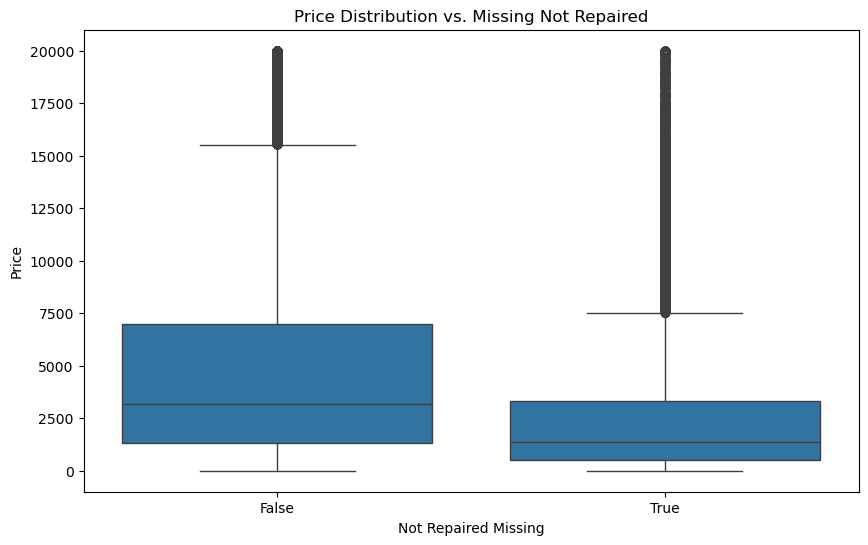

In [50]:
# Check for bias on missing values
df['not_repaired_missing'] = df['not_repaired'].isna()

plt.figure(figsize=(10,6))
sns.boxplot(x='not_repaired_missing', y='price', data=df)
plt.title('Price Distribution vs. Missing Not Repaired')
plt.xlabel('Not Repaired Missing')
plt.ylabel('Price')
plt.show()

__CONCLUSIONS & COMMENTARY:__
- The boxplot above plots the distribution of records where the `not_repaired` value is not missing vs. the distribution when it is missing.
- Overall, the population that is not missing values in `not_repaired` contains the distribution of those price points where the value is missing, suggesting that there is no implicit bias in the data that would create pause for thought in dropping the data.

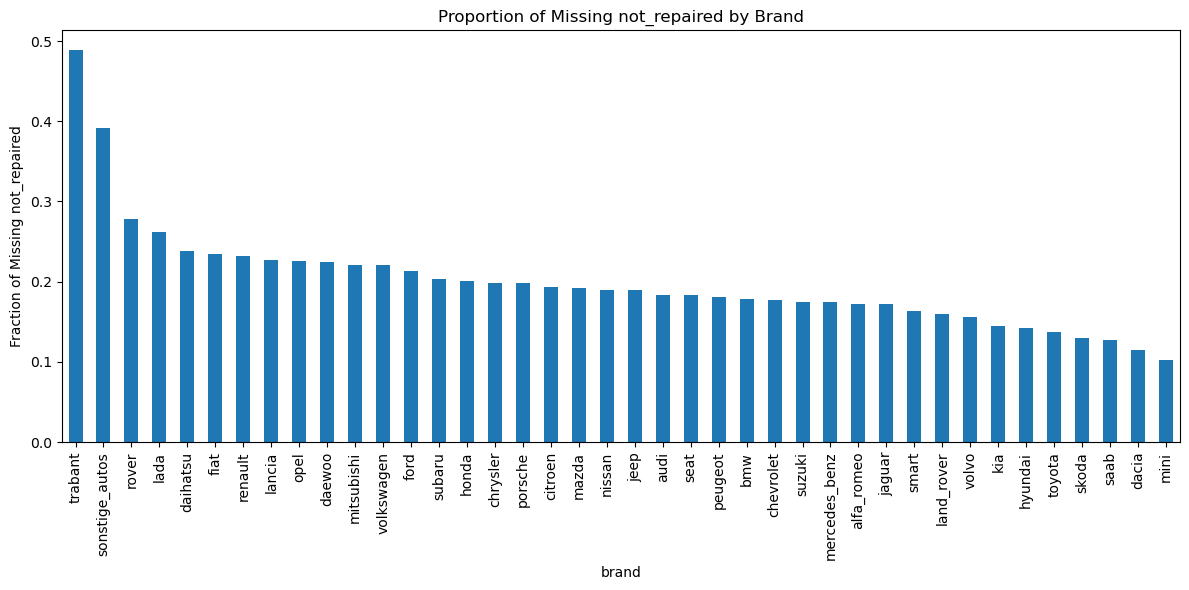

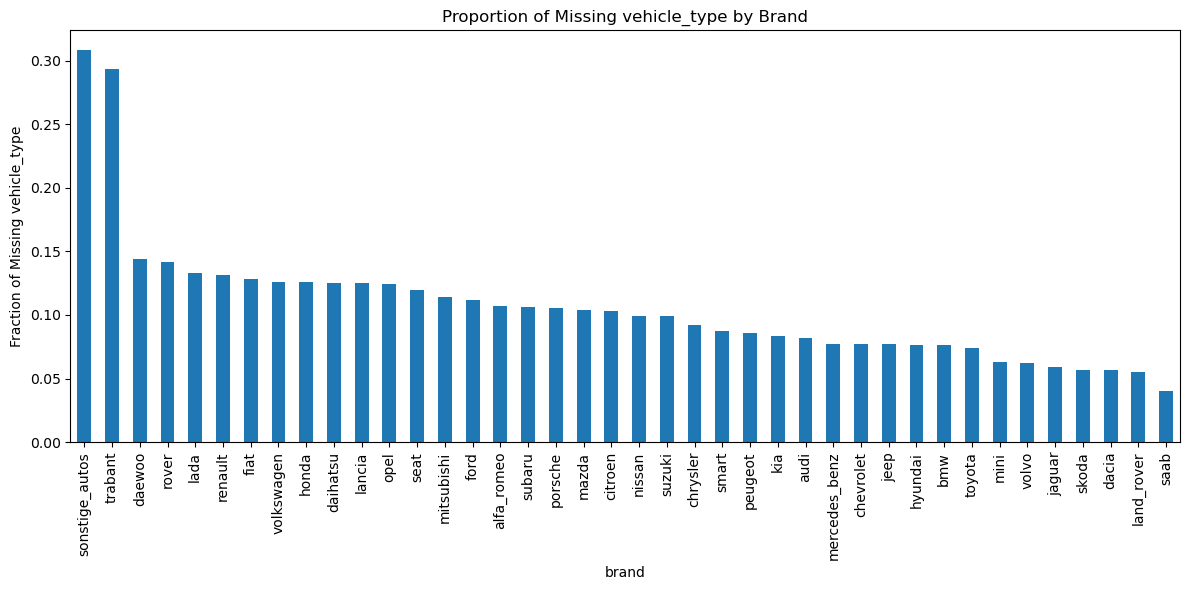

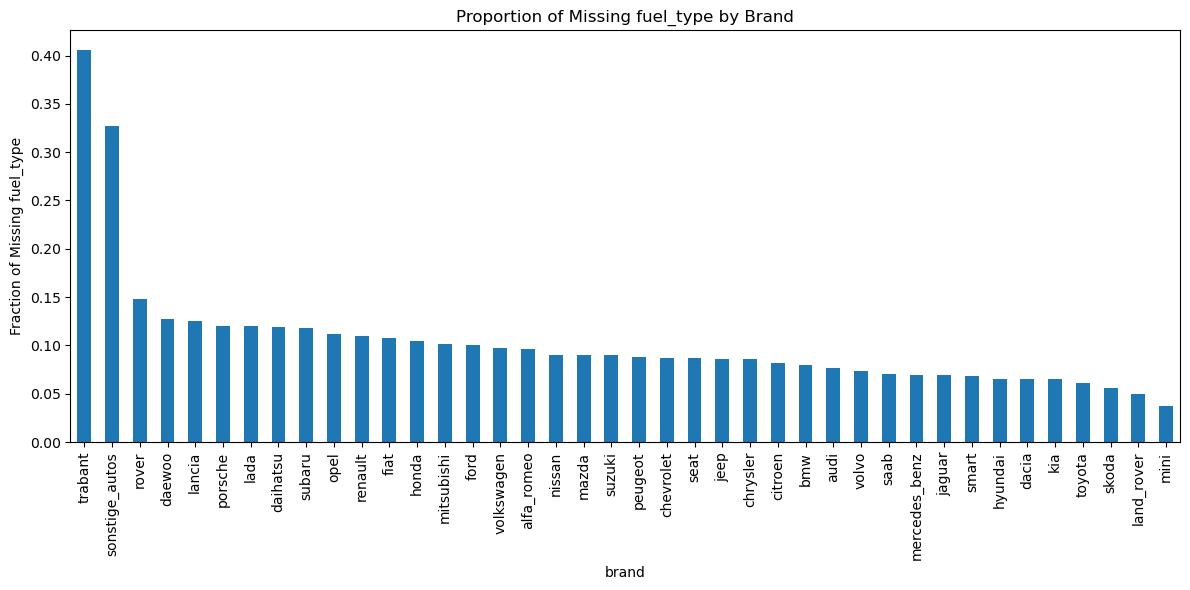

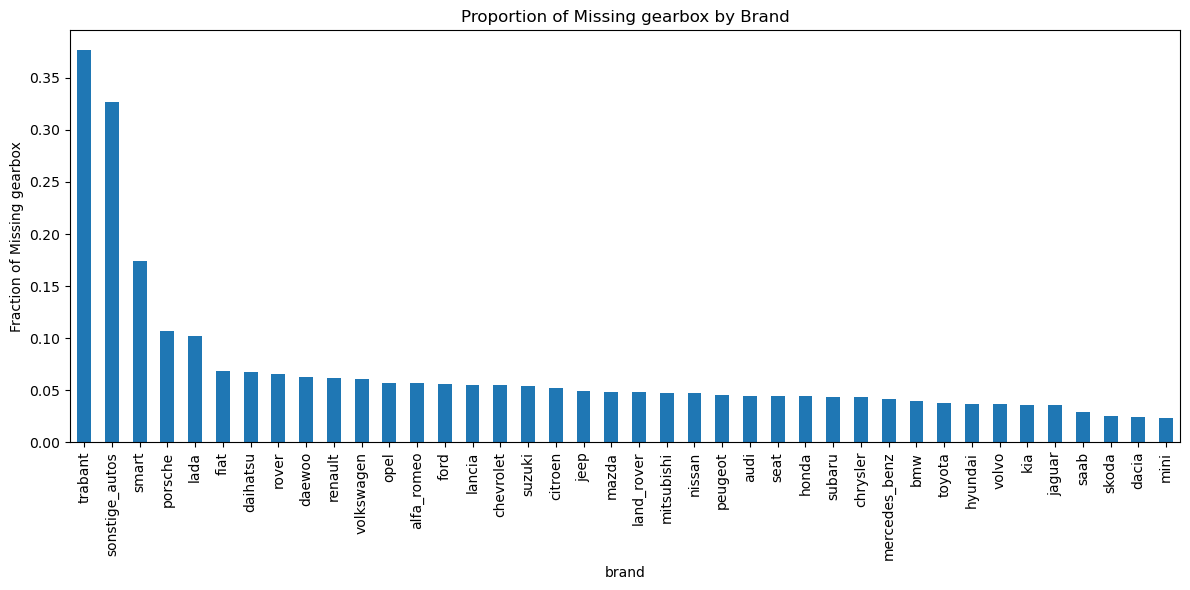

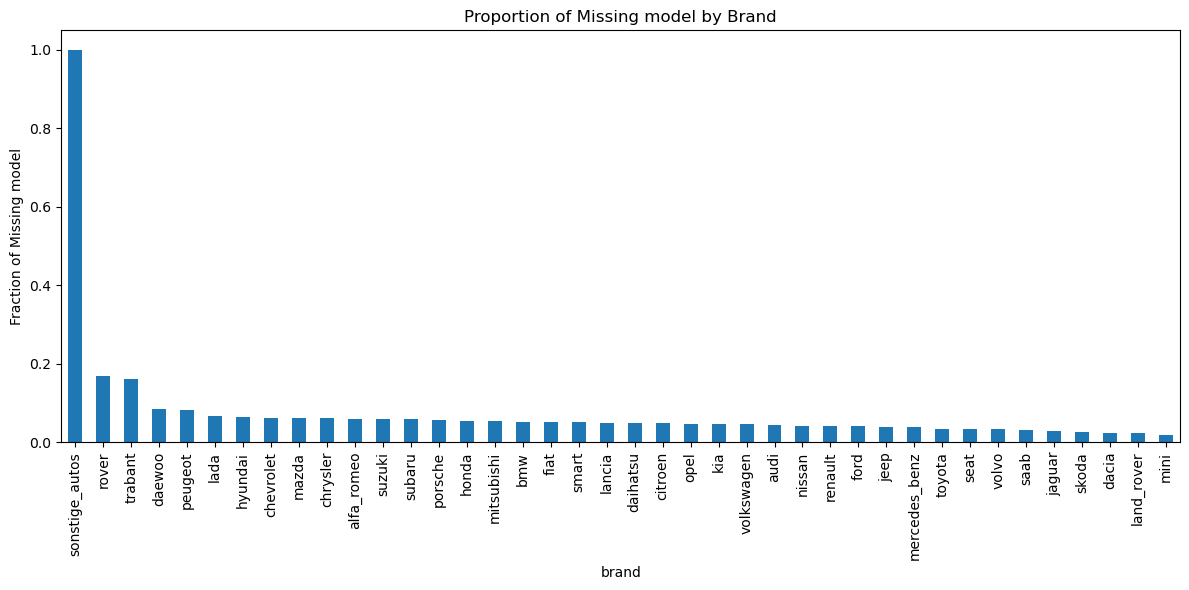

In [51]:
# Check categorical skew
for col in['not_repaired', 'vehicle_type', 'fuel_type', 'gearbox', 'model']:
    missing_flag = f'{col.lower()}_missing'
    df[missing_flag] = df[col].isna()

    missing_by_brand = df.groupby('brand')[missing_flag].mean().sort_values(ascending=False)
    plt.figure(figsize=(12,6))
    missing_by_brand.plot(kind='bar')
    plt.title(f'Proportion of Missing {col} by Brand')
    plt.ylabel(f'Fraction of Missing {col}')
    plt.tight_layout()
    plt.show()


__CONCLUSIONS & COMMENTARY:__
- The rows that had a missing value for the columns that contained missing values were analyzed by `brand` to determine if there were any underrepresented and/or poorly researched brands that could be problematic in modeling the data.
- Standouts in all missing value columns were the **sonstige_autos** and **trabant** brands.
- These brands should be dropped to eliminate the skew and reduce the noise.

In [52]:
# Drop underrepresented and poorly researched brands
brands_to_drop = ['sonstige_autos', 'trabant']
df = df[~df['brand'].isin(brands_to_drop)]

# Replace remaining rows with missing values in key features with stand-in value
key_features = ['not_repaired', 'vehicle_type', 'fuel_type', 'gearbox', 'model'] 
df[key_features] = df[key_features].fillna('Unknown')
df = df.reset_index(drop=True)


# Drop uninformative or problematic columns
cols_to_drop = [
    'postal_code',
    'registration_month',
    'registration_year',
    'number_of_pictures',
    'last_seen',
    'not_repaired_missing',
    'vehicle_type_missing',
    'fuel_type_missing',
    'gearbox_missing',
    'model_missing'
]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Verify there are no remaining missing values
display(f"Remaining rows: {df.shape[0]}")
print()
display(df.info())

'Remaining rows: 350406'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350406 entries, 0 to 350405
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_crawled  350406 non-null  datetime64[ns]
 1   price         350406 non-null  int64         
 2   vehicle_type  350406 non-null  object        
 3   gearbox       350406 non-null  object        
 4   power         350406 non-null  int64         
 5   model         350406 non-null  object        
 6   mileage       350406 non-null  int64         
 7   fuel_type     350406 non-null  object        
 8   brand         350406 non-null  object        
 9   not_repaired  350406 non-null  object        
 10  date_created  350406 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(6)
memory usage: 29.4+ MB


None

__CONCLUSIONS & COMMENTARY:__
- This codeblock removes the underrepresented brands in the missing value columns identified in the above bar charts (**sonstige_autos** and **trabant**).
- Remaining rows from the missing values columns were filled with **'Unknown'**.
- Several columns were determined to be disruptive to the forthcoming model training and added nothing to predictive considerations, including :`postal_code`, `registration_month`, `registration_year`, `date_crawled`, `date_created`, `number_of_pictures`, `last_seen`, `not_repaired_missing`, `vehicle_type_missing`, `fuel_type_missing`, `gearbox_missing`, and `model_missing`.
- With those changes, over 350,000 rows still remain.

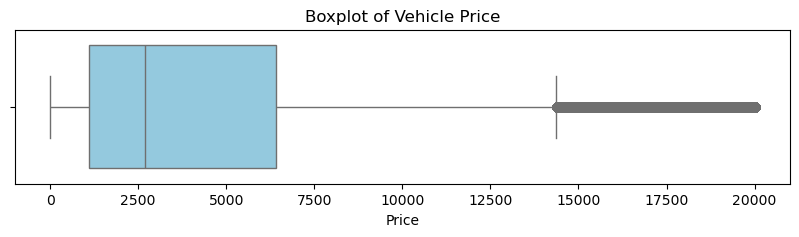

In [53]:
# Check distribution of target only
plt.figure(figsize=(10, 2)) 
sns.boxplot(x=df['price'], color='skyblue')

plt.title('Boxplot of Vehicle Price')
plt.xlabel('Price')
plt.show()

__CONCLUSIONS & COMMENTARY:__
- The target `price` column shall now be examined in greater detail.
- The boxplot above shows that there are large number of vehicles where €0 were entered as the vehicle price - these rows should be removed as this is inaccurate data - no vehicle is sold for free.
- There is also a very dense population of outliers bunched up above the €15,000 mark - these should also be removed to mitigate model skewing.

count    294569.000000
mean       4322.801727
std        3598.509003
min         501.000000
25%        1499.000000
50%        3000.000000
75%        6299.000000
max       14999.000000
Name: price, dtype: float64


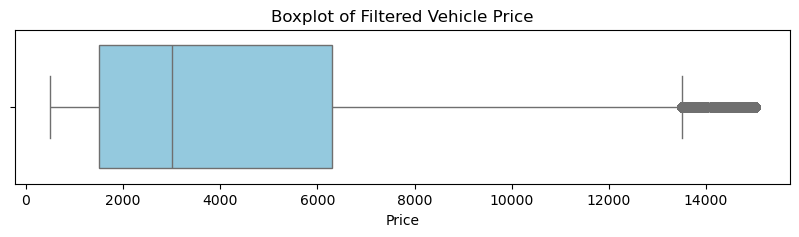

In [54]:
# Drop rows where the price is 0/low or is excessively high and not representative of the population
df = df[(df['price'] > 500) & (df['price'] < 15000)]

# Check
print(df['price'].describe())
plt.figure(figsize=(10, 2)) 
sns.boxplot(x=df['price'], color='skyblue')
plt.title('Boxplot of Filtered Vehicle Price')
plt.xlabel('Price')
plt.show()

__CONCLUSIONS & COMMENTARY:__
- After applying the filters on the `price` column to restrict the more values to rest more realistically between €500 and €15,000, the number of outliers has fallen significantly, and we have mitigated the skew without excluding the possibility that there are going to some higher value used vehicles.
- The `describe` table above the boxplot shows a more realistic interquartile spread as well.

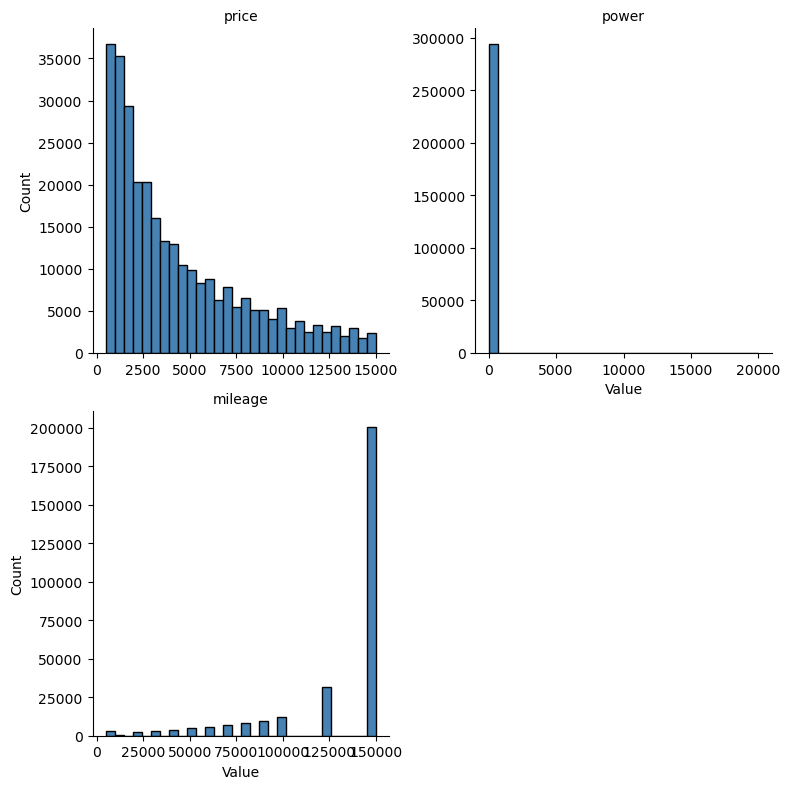

In [55]:
# Check distributions of different numerical features and target
cols_to_plot = ['price', 'power', 'mileage']

# Melt df to make each column a feature with values
df_melted = df[cols_to_plot].melt(var_name='feature', value_name='value')

# FacetGrid the histos
g = sns.FacetGrid(df_melted, col='feature', col_wrap=2, height=4, sharex=False, sharey=False)
g.map(plt.hist, 'value', bins=30, color='steelblue', edgecolor='black')

# Format
g.set_titles(col_template="{col_name}")
g.set_axis_labels('Value', 'Count')
plt.tight_layout()
plt.show()

__CONCLUSIONS & COMMENTARY:__
- In this codeblock, we visualize the distribution of the target `price`, as well as the `mileage` and `power` columns, to ensure the filtering still looks realistic from histogram perspective, and review if there are any concerns in the feature distributions.
- The target `price` remains looking realistic, where it is expected that the price of used vehicles would skew on the cheaper side.
- The `mileage` feature is realistic as well, as many used cars are sold when more than 100,000 miles have been accrued - though it appears as though there is an outlier, this spread aligns with industry standards.
- There is a clear issue with the `power` feature, as there is no vehicle that has 0 hp, and based on the analysis further above, it is incorrect to state that there are vehicles with 20,000 hp as well.
    - A filter for `power` between 20 and 1000 hp shall be applied to the column adn the data shall be re-analyzed below.

count    294569.000000
mean        112.479290
std         190.547056
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


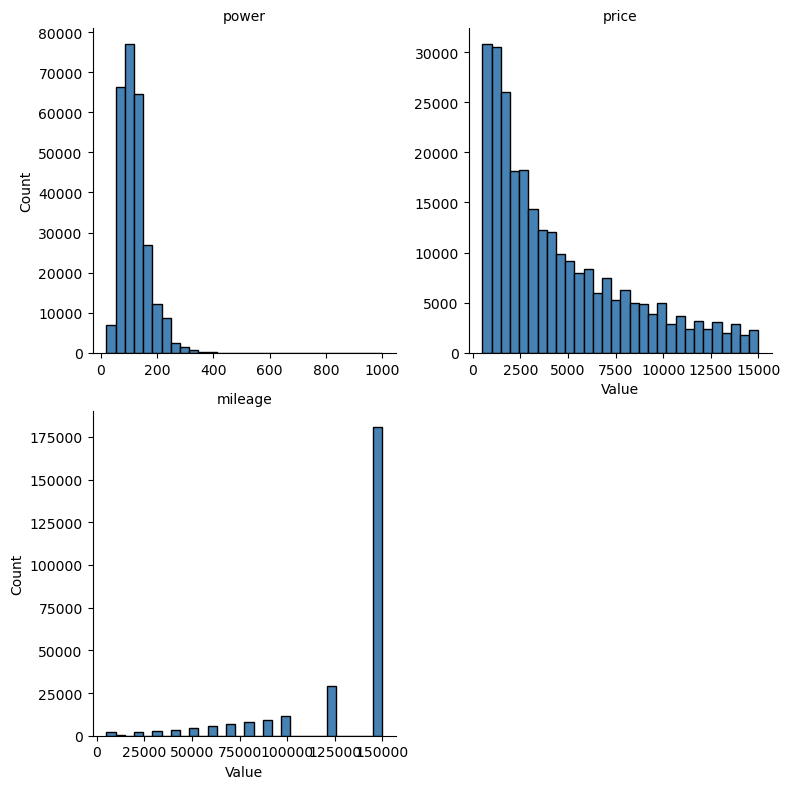

In [56]:
# Review the spread for the power outliers
print(df['power'].describe())

# Filter to a realistic power range
df_filtered = df[(df['power'] >= 20) & (df['power'] <= 1000)]

# Replot and review
cols_to_plot = ['power', 'price', 'mileage']
df_melted = df_filtered[cols_to_plot].melt(var_name='feature', value_name='value')

g = sns.FacetGrid(df_melted, col='feature', col_wrap=2, height=4, sharex=False, sharey=False)
g.map(plt.hist, 'value', bins=30, color='steelblue', edgecolor='black')
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Count")
plt.tight_layout()
plt.show()

__CONCLUSIONS & COMMENTARY:__
- Removing the noise from the `power` column with the 20 to 1000 hp filter cleaned the data up nicely.
- The distribution of values is much more realistic, with many of the used vehicles showing between 20 and 400 hp along a normal distribution curve.

In [57]:
# Verify current amount of rows for model integrity
df = df_filtered.reset_index()
df.info()
print()
print(df.describe())
print()
print('There are', df.duplicated().sum(), 'duplicated rows.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267785 entries, 0 to 267784
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   index         267785 non-null  int64         
 1   date_crawled  267785 non-null  datetime64[ns]
 2   price         267785 non-null  int64         
 3   vehicle_type  267785 non-null  object        
 4   gearbox       267785 non-null  object        
 5   power         267785 non-null  int64         
 6   model         267785 non-null  object        
 7   mileage       267785 non-null  int64         
 8   fuel_type     267785 non-null  object        
 9   brand         267785 non-null  object        
 10  not_repaired  267785 non-null  object        
 11  date_created  267785 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 24.5+ MB

               index                   date_crawled          price  \
count  267785.000000              

In [58]:
# Create modeling-ready copy
df_modeling = df.copy()

# Extract features from datetimes
df_modeling['year_created'] = df_modeling['date_created'].dt.year
df_modeling['month_created'] = df_modeling['date_created'].dt.month
df_modeling['year_crawled'] = df_modeling['date_crawled'].dt.year
df_modeling['month_crawled'] = df_modeling['date_crawled'].dt.month

# Drop raw datetime fields to prevent OHE cardinality bomb
df_modeling.drop(columns=['date_created', 'date_crawled'], inplace=True)
print()
print('There are', df_modeling.duplicated().sum(), 'duplicated rows.') # Extra duplicate check per feedback
print()
print(df_modeling.info())


There are 0 duplicated rows.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267785 entries, 0 to 267784
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   index          267785 non-null  int64 
 1   price          267785 non-null  int64 
 2   vehicle_type   267785 non-null  object
 3   gearbox        267785 non-null  object
 4   power          267785 non-null  int64 
 5   model          267785 non-null  object
 6   mileage        267785 non-null  int64 
 7   fuel_type      267785 non-null  object
 8   brand          267785 non-null  object
 9   not_repaired   267785 non-null  object
 10  year_created   267785 non-null  int32 
 11  month_created  267785 non-null  int32 
 12  year_crawled   267785 non-null  int32 
 13  month_crawled  267785 non-null  int32 
dtypes: int32(4), int64(4), object(6)
memory usage: 24.5+ MB
None


__CONCLUSIONS & COMMENTARY:__
- With all of the filters and columns dropped to eliminate noise and inaccuracies, we are left with a little over 267,000 rows, which is sufficient to proceed with model training and evaluation.

## 3. Model Training

In [59]:
# Shared train/test split

# 1. Copy cleaned data and separate target
targ = df_modeling['price']
feat = df_modeling.drop('price', axis=1)

# 2. Single train/test split
feat_train, feat_test, targ_train, targ_test = train_test_split(
    feat, targ, test_size=0.2, random_state=state
)

# 3. Cardinality limiter function (returns clean copy)
def limit_categories(df, col, top_n=20):
    top = df[col].value_counts().nlargest(top_n).index
    df = df.copy()  # avoid SettingWithCopyWarning
    df[col] = df[col].where(df[col].isin(top), other='other')
    return df

# 4. Impose limits on training set for OHE control
feat_train = limit_categories(feat_train, 'model', 25)
feat_train = limit_categories(feat_train, 'brand', 15)

# 5. Mirror limits on test set (based on training categories)
feat_test = feat_test.copy()
for col in ['model', 'brand']:
    allowed = feat_train[col].unique()
    feat_test[col] = np.where(feat_test[col].isin(allowed), feat_test[col], 'other')

# 6. Identify column types for transformation pipeline
cat_cols = feat_train.select_dtypes(include='object').columns.tolist()
num_cols = feat_train.select_dtypes(exclude='object').columns.tolist()


### 3.1 Linear Regression (Baseline)

In [60]:

# Preprocessing
preprocessor_lr = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', MaxAbsScaler(), num_cols)
])

feat_train_lr = preprocessor_lr.fit_transform(feat_train)

# Cross-validation
lr_model = LinearRegression(positive=True)
lr_results = repeated_random_cv_full(feat_train_lr, targ_train, lr_model)


Avg RMSE: 2971.94
Avg Training Time per Fold: 0.5933 seconds
Avg Prediction Time per Fold: 0.0031 seconds


__CONCLUSIONS & COMMENTARY:__
- The data contains a mix of categorical and numeric data, and for the `LinearRegression()` to perform at its best, I:
    -  Limited the cardinality of two very diverse categorical columns (`model` and `brand`)
    -  Applied `OneHotEncoder()` to the categorical columns to allow for accurate training and equalize the importance of the columns
    -  Applied `MaxAbsScaler` to the numeric columns to equalize the importance of the various columns in training
- The custom cross validation functioned defined in **Section 2**, `repeated_random_cv_full()`, was deployed on the model to fold the model 5 times, selecting a new 25 percent of the overall training set to hold out for validation testing that was used in the training for eeach fold.
- As it is not possible to sell a used vehicle for negative euros, the `positive` parameter for the `LinearRegression` function was set to **True**.
- The **RMSE** left much to be desired at €2971.95 in spite of the fast modeling and prediction time per cross-validation fold, as expected for the baseline model. 

### 3.2 RandomForestRegressor 

In [61]:
# 1. Copy pre-split training data
rf_feats_train = feat_train.copy()
rf_targ_train = targ_train.copy()

# 2. Encode categoricals (ordinal to allow for tree splits)
encoder_rf = OrdinalEncoder()
rf_feats_train[cat_cols] = encoder_rf.fit_transform(rf_feats_train[cat_cols])

# 3. Define hyperparameter ranges
depths = [5, 10, 20, None]
n_est = [50, 100, 200]
param_grid = [(depth, n_estimators) for depth in depths for n_estimators in n_est]

# 4. Run grid search across combinations
results = []

for depth, n_estimators in tqdm(param_grid, desc="Running RF Grid Search"):
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=depth,
        random_state=state,
        n_jobs=-1
    )
    result = repeated_random_cv_full(rf_feats_train, rf_targ_train, model)
    results.append({
        'max_depth': depth,
        'n_estimators': n_estimators,
        'rmse': result['rmse'],
        'train_time': result['train_time'],
        'pred_time': result['pred_time']
    })

# 5. Summarize
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('rmse')
display(results_df)

Running RF Grid Search:   0%|          | 0/12 [00:00<?, ?it/s]

Avg RMSE: 2533.72
Avg Training Time per Fold: 0.5976 seconds
Avg Prediction Time per Fold: 0.0301 seconds
Avg RMSE: 2526.48
Avg Training Time per Fold: 1.0307 seconds
Avg Prediction Time per Fold: 0.0324 seconds
Avg RMSE: 2533.21
Avg Training Time per Fold: 1.9043 seconds
Avg Prediction Time per Fold: 0.0511 seconds
Avg RMSE: 2175.81
Avg Training Time per Fold: 0.9286 seconds
Avg Prediction Time per Fold: 0.0299 seconds
Avg RMSE: 2172.67
Avg Training Time per Fold: 1.6454 seconds
Avg Prediction Time per Fold: 0.0408 seconds
Avg RMSE: 2162.56
Avg Training Time per Fold: 3.0870 seconds
Avg Prediction Time per Fold: 0.0616 seconds
Avg RMSE: 1948.52
Avg Training Time per Fold: 1.5855 seconds
Avg Prediction Time per Fold: 0.0642 seconds
Avg RMSE: 1940.86
Avg Training Time per Fold: 2.9285 seconds
Avg Prediction Time per Fold: 0.1044 seconds
Avg RMSE: 1932.96
Avg Training Time per Fold: 5.8511 seconds
Avg Prediction Time per Fold: 0.2017 seconds
Avg RMSE: 2000.63
Avg Training Time per Fold: 

,max_depth,n_estimators,rmse,train_time,pred_time
8,20.0,200,1932.957072,5.851117,0.201681
7,20.0,100,1940.858827,2.928540,0.104437
6,20.0,50,1948.521680,1.585461,0.064248
11,NaN,200,1994.219980,7.076425,0.365685
10,NaN,100,1996.619683,3.848122,0.190973
9,NaN,50,2000.634925,2.008935,0.116243
5,10.0,200,2162.561495,3.086953,0.061578
4,10.0,100,2172.674577,1.645350,0.040790
3,10.0,50,2175.810639,0.928556,0.029931
1,5.0,100,2526.481736,1.030708,0.032406


__CONCLUSIONS & COMMENTARY:__
- The data contains a mix of categorical and numeric data, and for the `RandomForestRegressor()` to perform at its best, I:
    -  Limited the cardinality of two very diverse categorical columns (`model` and `brand`)
    -  Applied `OrdinalEncoder()` to the categorical columns to allow for accurate training and equalize the importance of the columns
- The model was iteratively tuned on several combinations of `max_depth` and `n_estimators` values.
- The custom cross validation functioned defined in **Section 2**, `repeated_random_cv_full()`, was deployed on the model to fold the model 5 times, selecting a new 25 percent of the overall training set to hold out for validation testing that was used in the training for eeach fold.
- The highest-performing **Random Forest Regressor** model was tuned to a `max_depth` of 20 and `n_estimators` of 200:
    - The **RMSE** in this case was 1932.96, a marked improvement over the baseline, although the training and prediction time went up.
- Though this was the highest performer, a more efficient model with similar **RMSE** had the following parameters:
    - **RMSE**: 1948.52
    - **Training Time**: 9.52 Seconds 
    - **Prediction Time**: 0.35 Seconds
    - `max_depth`: 20.0
    - `n_estimators`: 50

### 3.3 LightGBM

In [62]:
# LightGBM Grid Search with Categorical Handling

# 1. Fresh copy from shared split
lgb_feats_train = feat_train.copy()
lgb_targ_train = targ_train.copy()

# 2. Limit cardinality on categoricals
limit_categories(lgb_feats_train, 'model', 25)
limit_categories(lgb_feats_train, 'brand', 15)

# 3. Convert to 'category' dtype for LGB
cat_cols_lgb = lgb_feats_train.select_dtypes(include='object').columns.tolist()
lgb_feats_train[cat_cols_lgb] = lgb_feats_train[cat_cols_lgb].astype('category')

# 4. Expanded grid based on prior block
base_params = [
    {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'num_leaves': 64, 'subsample': 0.8, 'colsample_bytree': 0.8},
    {'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.05, 'num_leaves': 128, 'subsample': 0.9, 'colsample_bytree': 0.9},
    {'n_estimators': 300, 'max_depth': -1, 'learning_rate': 0.10, 'num_leaves': 128, 'subsample': 0.9, 'colsample_bytree': 0.9},
    {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.03, 'num_leaves': 200, 'subsample': 1.0, 'colsample_bytree': 1.0},
]

from copy import deepcopy
min_child_samples_vals = [10, 20, 50]
lgb_param_grid = []

for base in base_params:
    for mcs in min_child_samples_vals:
        param_combo = deepcopy(base)
        param_combo['min_child_samples'] = mcs
        lgb_param_grid.append(param_combo)

# 5. Suppress LGB warnings about categorical_feature
warnings.filterwarnings('ignore', message='Using categorical_feature in Dataset.')

# 6. Cross-validate
results_lgb = []

for params in tqdm(lgb_param_grid, desc='LightGBM Grid Search'):
    model = LGBMRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        num_leaves=params['num_leaves'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        min_child_samples=params['min_child_samples'],
        random_state=state,
        n_jobs=-1
    )
    result = repeated_random_cv_full(
        lgb_feats_train,
        lgb_targ_train,
        model,
        cat_features=cat_cols_lgb
    )
    results_lgb.append({
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'num_leaves': params['num_leaves'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'min_child_samples': params['min_child_samples'],
        'rmse': result['rmse'],
        'train_time': result['train_time'],
        'pred_time': result['pred_time']
    })

# 7. Rank and display
results_df_lgb = pd.DataFrame(results_lgb).sort_values('rmse')
display(results_df_lgb)

LightGBM Grid Search:   0%|          | 0/12 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 160671, number of used features: 12
[LightGBM] [Info] Start training from score 4471.150954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 160671, number of used features: 12
[LightGBM] [Info] Start training from score 4478.587387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

,n_estimators,max_depth,learning_rate,num_leaves,subsample,colsample_bytree,min_child_samples,rmse,train_time,pred_time
8,300,-1,0.10,128,0.9,0.9,50,1853.615226,1.722191,0.090659
7,300,-1,0.10,128,0.9,0.9,20,1854.056651,1.556120,0.079897
11,500,20,0.03,200,1.0,1.0,50,1859.183554,4.010179,0.258973
10,500,20,0.03,200,1.0,1.0,20,1865.548631,4.295142,0.219304
6,300,-1,0.10,128,0.9,0.9,10,1866.732132,1.516631,0.065453
9,500,20,0.03,200,1.0,1.0,10,1872.455698,3.970416,0.203844
5,300,15,0.05,128,0.9,0.9,50,1880.014231,1.481091,0.100382
4,300,15,0.05,128,0.9,0.9,20,1884.254227,1.657912,0.087909
3,300,15,0.05,128,0.9,0.9,10,1884.502907,1.592285,0.082221
2,300,10,0.05,64,0.8,0.8,50,1924.820285,0.956748,0.082232


__CONCLUSIONS & COMMENTARY:__
- The data contains a mix of categorical and numeric data, and for the `LGBMRegressor()` to perform at its best, I:
    -  Limited the cardinality of two very diverse categorical columns (`model` and `brand`)
    -  Converted the categorical columns to the `category` type to allow for `LGBMRegressor` to use it's native categorical processing.
- The model was iteratively tuned on several combinations of the following hyperparameters:
    - `max_depth`
    - `n_estimators`
    - `learning_rate`
    - `num_leaves`
    - `subsample`
    - `colsample_bytree`
    - `min_child_samples`
- The custom cross validation functioned defined in **Section 2**, `repeated_random_cv_full()`, was deployed on the model to fold the model 5 times, selecting a new 25 percent of the overall training set to hold out for validation testing that was used in the training for each fold.
- The most-efficient, high-performing **LGBMRegressor** model was tuned as follows:
    - `n_estimators`: 300
    - `max_depth`: -1
    - `learning_rate`: 0.10
    - `num_leaves`: 128
    - `subsample`: 0.9
    - `colsample_bytree`: 0.9
    - `min_child_samples`: 50
    - The **RMSE** in this case was 1853.62, a slight improvement over the **RandomForestRegressor**, although the training and prediction time went up slightly as well.

## 4. Model Analysis

The table below summarizes the performance of all three models based on cross-validation applied only to the training data. The best-performing LightGBM and Random Forest configurations are shown alongside Linear Regression for comparison.
 
| Model             | RMSE (Train CV) | Train Time (s) | Predict Time (s) | Parameters                                                                 |
|-------------------|-----------------|----------------|------------------|----------------------------------------------------------------------------|
| Linear Regression | 2971.95         |  1.5587         | 0.0037           | n/a                                                                        |
| Random Forest     | 1948.52         | 9.5246        | 0.3506           | max_depth=20, n_estimators=50                                              |
| LightGBM          | 1853.62         |  7.2219         | 0.0907           | max_depth=-1, n_estimators=300, num_leaves=128, min_child_samples=50, learning_rate=0.10, subsample=0.9, colsample_bytree=0.9     |

**Takeaway**: 
- Though LightGBM showed the lowest RMSE, Random Forest had an acceptable RMSE and faster prediction times, which is preferable for a real-time application. 
- Based on these results, RandomForestRegressor was selected as the final model to evaluate on the untouched test set.

## 5. Model Testing - Best Random Forest

In [63]:
# 1. Copy and encode test features using training encoder
rf_feats_test = feat_test.copy()
rf_feats_test[cat_cols] = encoder_rf.transform(rf_feats_test[cat_cols])

# 2. Define best model
best_rf_model = RandomForestRegressor(
    max_depth=20,
    n_estimators=50,
    random_state=state,
    n_jobs=-1
)

# 3. Train and time on full training set
start_train = time.time()
best_rf_model.fit(rf_feats_train, rf_targ_train)
train_duration = time.time() - start_train

# 4. Predict and time on test set
start_pred = time.time()
rf_preds_test = best_rf_model.predict(rf_feats_test)
pred_duration = time.time() - start_pred

# 5. Evaluate
rf_test_rmse = np.sqrt(mean_squared_error(targ_test, rf_preds_test))

# 6. results
print(f"Random Forest Test RMSE: {rf_test_rmse:.2f}")
print(f"Training Time: {train_duration:.4f} seconds")
print(f"Prediction Time: {pred_duration:.4f} seconds")


Random Forest Test RMSE: 1895.97
Training Time: 2.2115 seconds
Prediction Time: 0.0748 seconds


## 6. Commentary & Recommendations

**Project Objectives:**
- The objective of this project is to present Rusty Bargain with predictive modeling options with recommendations grounded on:
    - Quality of predictions,
    - Speed of predictions, and
    - Time required for training.

**Results Summary:**
- The test results in **Section 5** display the strongest/tuned version of the `RandomForestRegressor` model.
- The `LGBMRegressor` has by far the strongest performance in terms of **RMSE**, outshining the other models especially when presented with the holdout test set.
- However, the primary drawback for the LightGBM model is the speed of training as well as prediction, where both the Random Forest and Linear Regression are significantly faster.
- The speed comes at the cost of generalization and fit. In training, the Random Forest was comparable in RMSE to the LightGBM model; however, when presented with unseen test data, the RMSE lost some ground when compared to the LightGBM model.
    - The outperformance on RMSE by LightGBM Regressor is not surprising, given its native categorical data processing specialties.
    - The Random Forest Regressor's speed with acceptable RMSE is a more suitable choice for this application, where predictive speed to support real-time responsiveness in the app is critical.
- Though the Linear Regression model is unmatched in training and prediction speed, it cannot compete in terms of generalization with the other models in either the training or test phases, adequately fulfilling its role as a baseline model.

**Next Steps & Recommendations:**
- Rusty Bargain should proceed with the `RandomForestRegressor` model tuned as defined above to inform its application.
- Taking steps to ensure data integrity is held to a higher standard at the front-end will contribute to further refinement of the model and further reductions in the **RMSE**.